In [47]:
import os, sys, math, gc
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import seaborn as sns
import lightgbm as lgb
import pickle as pkl
from utils.utils import merge_eval_sold_on_df, sort_df_on_d, WRMSSE, RMSSE, _down_cast, data_preprocessing, diff_lists, log_status
from utils.utils import customIter, cross_validation_on_validation_set, ensemble_submissions, ensemble_submissions_uncertainty
from utils.metrics import WSPL
from utils.configure_logger import configure_logger
from utils.utils import prefixes_in_column, prefix_in_column, parse_columns_to_string
from utils import constants

configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [48]:
DATA_BASE_PATH = constants.DATA_BASE_PATH #'../data/m5-forecasting-accuracy/'
DATA_BASE_PATH_UNCERTAINTY = constants.DATA_BASE_PATH_UNCERTAINTY #'../data/m5-forecasting-uncertainty/'
SALES_EVALUATION = constants.SALES_EVALUATION 
SALES_VALIDATION = constants.SALES_VALIDATION
CALENDAR = constants.CALENDAR 
SAMPLE_SUBMISSION = constants.SAMPLE_SUBMISSION 
SELL_PRICES = constants.SELL_PRICES

PRECOMPUTED_BASE_PATH = constants.PRECOMPUTED_BASE_PATH #'../data/uncertainty/features/'

DAYS: int = constants.DAYS #28
QUANTILES: int = constants.QUANTILES 

AGG_LEVEL_COLUMNS = constants.AGG_LEVEL_COLUMNS
D_CROSS_VAL_START_LIST = constants.D_CROSS_VAL_START_LIST

# to simple get the precomputed name
precomputed_name = lambda store, eval_val: f'processed_{store}_{eval_val}.pkl'

TEST_PATH = constants.TEST_PATH#'test/'
PREDICTION_BASE_PATH = constants.PREDICTION_BASE_PATH #'../data/uncertainty/temp_submissions/'
SUBMISSION_BASE_PATH = constants.SUBMISSION_BASE_PATH #'../data/uncertainty/final_submissions/'

SUB_D_START_VAL: int = constants.SUB_D_START_VAL
SUB_D_START_EVAL: int = constants.SUB_D_START_EVAL

# the columns are always included after feature processing
# because they are required in the training and submission format
DROP_FEATURE_COLUMNS: list = constants.DROP_FEATURE_COLUMNS #['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'sold']

### Define GridSearch functions

In [49]:
# all groups: seasonal, auto, autoquantiles, momentum
SPARSE_FEATURES = [
    'autoquantiles_sold_ma_28_0.5', 'auto_sold_ma_28', 'auto_sold_ma_168', 'autoquantiles_sold_ma_168_0.165','autoquantiles_sold_ma_168_0.835',
]
SPARSE_FEATURES += [f'seasonal_weekday_{i}' for i in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
SPARSE_FEATURES += [f'seasonal_monthday_{i}' for i in range(1,32)]
SPARSE_FEATURES += [f'seasonal_month_{i}' for i in range(1,13)]
# SPARSE_FEATURES += [f'state_{i}' for i in ['CA', 'TX', 'WI']]

USE_ALL = False
SPARSE_FEATURES = None
PLOT_PREDICTIONS = True

undersampling_dict = {
    # 'Level5': .15,
    # 'Level6': .15,
    # 'Level7': .15,
    # 'Level8': .15,
    # 'Level9': .1,
    'Level10': .001,
    'Level11': .0001,
    'Level12': .00001
}

HIGH_UNDERSAMPLING = True
TEST_NUMBER = 1
TEST_NUMB = 0

ALL_PREFIXES = ['auto_sold_', 'auto_sold_ma', 'auto_sold_std', 'auto_sold_ewm', 'autoquantiles_sold_qtile',
    'price_momentum','seasonal_','seasonal_weekday','seasonal_monthday','seasonal_month',
]

EXCLUDE_COLUMNS_LIST = ()
INCLUDE_COLUMNS_LIST = [
    # ['auto', 'price', 'seasonal'],
    # ['auto_sold_ma'],
    # ['auto_sold_ewm'],
    # ['auto_sold_56', 'auto_sold_14', 'auto_sold_7', 'auto_sold_1', 'auto_sold_2', 'seasonal', 'price'],
    # ['seasonal'],
    [
        'auto_sold_ewm',
    ],
    [
        'seasonal_weekday',
        'auto_sold_ewm',
    ],
    [
        'seasonal_monthday',
        'auto_sold_ewm',
    ],
    [
        'seasonal_weekday',
        'seasonal_monthday',
        'auto_sold_ewm'
    ],
    [
        'seasonal_',
        'auto_sold_ewm',
    ],
]

### Get all options

In [50]:
from utils.utils import load_results_as_json
r = load_results_as_json('../data/uncertainty/all_results.json')
list(r.keys())

['include_auto_price_seasonal',
 'include_auto_sold_56_auto_sold_14_auto_sold_7_auto_sold_1_auto_sold_2_seasonal_price',
 'include_auto_seasonal',
 'include_auto_seasonal_store_state',
 'include_seasonal_weekday_seasonal_monthday_auto_sold_ewm_100_auto_sold_ewm_30_autoquantiles_sold_qtile_28_0.5_auto_sold_ma_28_autoquantiles_sold_qtile_28_0.9',
 'include_seasonal_weekday_seasonal_monthday_auto_sold_ewm_100_auto_sold_ewm_30_autoquantiles_sold_qtile_28_0.5_auto_sold_ma_28_autoquantiles_sold_qtile_28_0.9_autoquantiles_sold_qtile_28_0.1',
 'include_seasonal_weekday_seasonal_monthday_seasonal_month_auto_sold_ewm_auto_sold_ma_autoquantiles',
 'include_seasonal_weekday_seasonal_monthday_auto_sold_ewm_100_auto_sold_ewm_30_autoquantiles_sold_qtile_28_0.5_auto_sold_ma_28_autoquantiles_sold_qtile_28_0.1',
 'include_seasonal_weekday_seasonal_monthday_auto_sold_ewm_100_auto_sold_ewm_30_autoquantiles_sold_qtile_28_0.5_auto_sold_ma_28',
 'include_seasonal_weekday_seasonal_monthday_auto_sold_ewm_100_a

### Load Models to Visualise Feature Importance

In [51]:
include_columns_list = [
    [
        'auto_sold_ewm',
    ],
    [
        'seasonal_weekday',
        'auto_sold_ewm',
    ],
    [
        'seasonal_monthday',
        'auto_sold_ewm',
    ],
    [
        'seasonal_weekday',
        'seasonal_monthday',
        'auto_sold_ewm'
    ],
    [
        'seasonal_',
        'auto_sold_ewm',
    ],
]
features = include_columns_list[-1]
# features = [
#     'seasonal_weekday',
#     'seasonal_monthday',
#     'seasonal_month',
#     'auto_sold_ewm',
#     'auto_sold_ma',
#     'autoquantiles',
# ]
level = 'Level1'

agg_columns = AGG_LEVEL_COLUMNS[level]
if len(agg_columns) == 0:
    agg_columns_str = 'Total_X'
elif len(agg_columns) == 1:
    agg_columns_str = agg_columns[0] + '_X'
else:
    agg_columns_str = '_'.join(agg_columns)
FOLD = 1914
import joblib
mod = joblib.load(f'../data/uncertainty/fold_{FOLD}/models/lgb_val_nt_{agg_columns_str}_include_{"_".join(features)}.joblib')

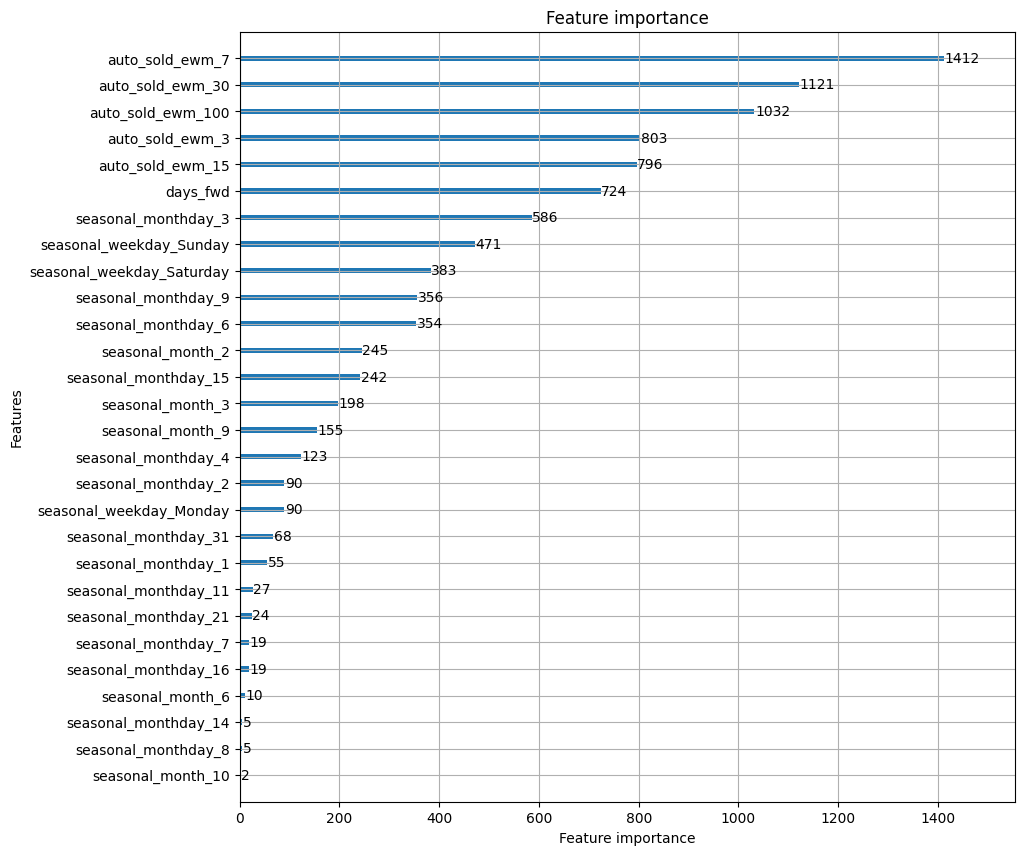

In [52]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
lgb.plot_importance(mod, ax=ax)
plt.show()

### Load Predictions and Plot Predictions

In [53]:
def read_concat_predictions(fold_name: int, exclude_columns: list = [], include_columns: list = [], use_all = False, load_submissions_path: str = 'temp_submissions/'):
    """
    For specified fold, read the predictions for all aggregation levels and stack them together in one dataframe.
    """
    # D_CV_START_LIST
    # if fold_name not in D_CV_START_LIST:
        # raise ValueError('fold_name must be a value in D_CV_START_LIST')
        
    exclude_columns = '_'.join(exclude_columns)
    if exclude_columns == '':
        exclude_columns = 'None'

    logger.info('loading files under path:' + f'../data/uncertainty/fold_{fold_name}/' + load_submissions_path)

    dfs: list = []
    for level in list(AGG_LEVEL_COLUMNS.keys())[:HIGHEST_LEVEL]:
        agg_columns = AGG_LEVEL_COLUMNS[level]
        group_names = '_'.join(agg_columns)
        if group_names == '':
            group_names = 'Total_X'
        
        file_path = f'../data/uncertainty/fold_{str(fold_name)}/' + load_submissions_path 
        file_path += f'lgb_val_nt_{group_names}_'
        if use_all:
            file_path += f'use_all.csv'  
        elif include_columns == None:
            file_path += f'exclude_{"_".join(exclude_columns)}.csv'            
        elif isinstance(include_columns, list):
            file_path += f'include_{"_".join(include_columns)}.csv'
        
        dfs.append(file_path)
    return ensemble_submissions_uncertainty(dfs)

In [54]:
# these variables are used later on
FORCE_RELOAD = False
try:
    # simple code to check if variable exists
    d_int + 1
    if FORCE_RELOAD:
        raise Exception()
except:
    # if not, load again
    # takes about 2-3 minutes to reload and parse
    d = pd.read_parquet('../data/uncertainty/cv_template/temp.parquet')
    d_int = pd.read_parquet('../data/uncertainty/cv_template/temp_d_int.parquet')['d_int']
    # d_int = d['d'].str.split('_').apply(lambda x: int(x[1]))
    # d_int.to_frame('d_int').to_parquet('../data/uncertainty/cv_template/temp_d_int.parquet', index = False)
    d['d_int'] = d_int

In [55]:
def perform_cv(df: pd.DataFrame, df_sub: pd.DataFrame):
    
    # to be able to merge
    df_sub['id_merge'] = df_sub['id'].str.split('.')\
        .apply(lambda x: x[0])
    df_sub['quantile'] = df_sub['id'].str.split('.')\
        .apply(lambda x: float('.'.join([x[-2], x[-1].split('_')[0]])))

    # merge predictions in cv template
    p = pd.merge(
        df,
        df_sub,
        how='right',
        on=['id_merge', 'd']
    )

    # for c in ['sold', 'revenue']:
    #     p[c] = p[c].astype(np.float32)
    # d = d[d_int < (D_CV_START + 28)]
    return p

In [56]:
# load predictions
FOLD = 1914
HIGHEST_LEVEL = 1
# INCLUDE_COLUMNS = ['auto', 'seasonal']
INCLUDE_COLUMNS =  [
        'seasonal_weekday',
        'seasonal_monthday',
        'auto_sold_ewm_100',
        'auto_sold_ewm_30',
        'autoquantiles_sold_qtile_28_0.5',
        'auto_sold_ma_28',
        'autoquantiles_sold_qtile_28_0.9',
        'autoquantiles_sold_qtile_28_0.1'
]
path = 'temp_submissions/'
data = read_concat_predictions(
    FOLD, 
    include_columns=INCLUDE_COLUMNS,
    use_all=False,
    load_submissions_path=path
)
rrr = perform_cv(
    _down_cast(d)[d_int < (FOLD + DAYS)], 
    data
)
rrr = rrr.set_index('d_int', drop=True)

2023-11-24 16:06:48 - __main__ - INFO - loading files under path:../data/uncertainty/fold_1914/temp_submissions/


2023-11-24 16:07:24 - __main__ - INFO - Total_X


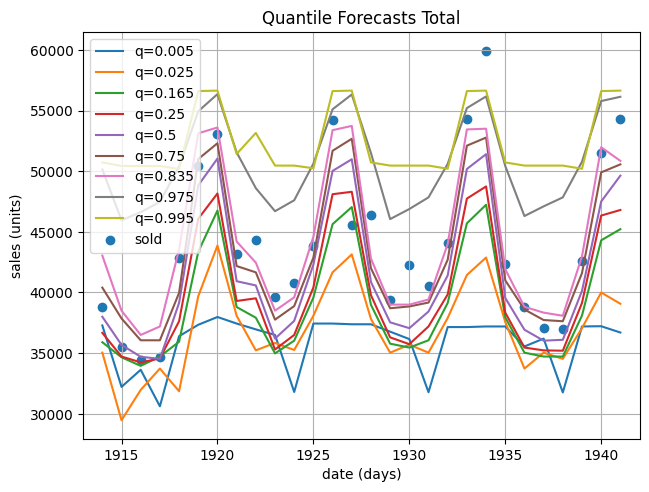

In [57]:
for group, df_temp in rrr.groupby('id_merge'):
    logger.info(group)
    # plot 
    for quantile in df_temp['quantile'].unique():
        df_temp[df_temp['quantile'] == quantile]['pred'].plot(label = f'q={quantile}')
        
    # plot actual sales
    idx = df_temp['quantile'] == quantile
    plt.scatter(df_temp[idx].index, df_temp[idx]['sold'], label = f'sold')
    
    # nice graph
    plt.xlim(FOLD-1, FOLD+DAYS)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.title('Quantile Forecasts Total')
    plt.xlabel('date (days)')
    plt.ylabel('sales (units)')
    plt.show()

### Load WSPL Scores

In [126]:
# EXPERIMENT: SEASONALITY FEATURES (>> DONE TILL LEVEL 9, ALL FOLDS)
EXPERIMENTS_DICT = {
    "seasonal": {
        "BASE": [],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ewm'],
            ['seasonal_weekday','auto_sold_ewm'],
            ['seasonal_monthday','auto_sold_ewm'],
            ['seasonal_weekday','seasonal_monthday','auto_sold_ewm'],
            ['seasonal_','auto_sold_ewm'],
        ]
    },
    "ewm vs. ma": {
        "BASE": ['seasonal_'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ewm'],
            ['auto_sold_ma'],
            ['auto_sold_ewm', 'auto_sold_ma'],
        ]
    },
    "quantiles vs. std": {
        "BASE": ['seasonal_', 'auto_sold_ma'],
        "INCLUDE_COLUMNS_LIST": [
            [],
            ['autoquantiles_'],
            ['auto_sold_std'],
            ['autoquantiles_','auto_sold_std'],   
        ]
    },
    "price auto/momentum": {
        "BASE": ['seasonal_', 'auto_sold_ma']
        "INCLUDE_COLUMNS_LIST": [
            ['price_auto'],
            ['price_momentum'],
            ['price_auto', 'price_momentum'],
        ]
    }
}

SyntaxError: invalid syntax (2793904711.py, line 32)

In [127]:
experiment_name = 'seasonal'
BASE = EXPERIMENTS_DICT[experiment_name]['BASE']
INCLUDE_COLUMNS_LIST = EXPERIMENTS_DICT[experiment_name]['INCLUDE_COLUMNS_LIST']
INCLUDE_COLUMNS_LIST = [BASE + i for i in INCLUDE_COLUMNS_LIST]

In [128]:
from utils.utils import load_results_as_json

In [129]:
def print_experiment_results(experiment_name):
    BASE = EXPERIMENTS_DICT[experiment_name]['BASE']
    INCLUDE_COLUMNS_LIST = EXPERIMENTS_DICT[experiment_name]['INCLUDE_COLUMNS_LIST']
    INCLUDE_COLUMNS_LIST = [BASE + i for i in INCLUDE_COLUMNS_LIST]
    
    r = load_results_as_json('../data/uncertainty/all_results.json')

    ### Compute DF comparing all averages
    r_all_folds = []
    r_ind_folds = []
    for features_def, results_all_folds in r.items():
        if features_def not in ['include_' + '_'.join(i) for i in INCLUDE_COLUMNS_LIST]:
            # print(features_def)
            # print(['_'.join(i) for i in INCLUDE_COLUMNS_LIST])
            continue
        features_global_sum = 0
        i = 0
        for fold, fold_results in results_all_folds.items():
            features_fold_sum = 0
            j = 0
            for level, wspl in fold_results.items():
                features_fold_sum += wspl
                j += 1
                features_global_sum += wspl
                i += 1
            r_ind_folds.append([features_def, fold, features_fold_sum / j, j])
        r_all_folds.append([features_def, features_global_sum / i])
        
    df_per_fold = pd.DataFrame(r_ind_folds, columns=['features', 'fold', 'avg_wspl', 'n_levels'])
    df_per_fold

    df_all = df_per_fold.groupby('features')['avg_wspl'].agg([np.average, np.std])
    logger.info(f'experiment: {experiment_name}')
    logger.info('\n' + str(df_all.sort_values('average')))

In [130]:
### ALL EXPERIMENTS
list(EXPERIMENTS_DICT.keys())

['seasonal', 'ewm vs. ma', 'quantiles vs. std']

In [132]:
print_experiment_results('seasonal')
print_experiment_results('ewm vs. ma')
print_experiment_results('quantiles vs. std')
print_experiment_results('price auto/momentum')

2023-11-24 17:50:12 - __main__ - INFO - experiment: seasonal
2023-11-24 17:50:12 - __main__ - INFO - 
                                                     average       std
features                                                              
include_seasonal_weekday_seasonal_monthday_auto...  0.200446  0.031677
include_seasonal__auto_sold_ewm                     0.201326  0.028314
include_seasonal_weekday_auto_sold_ewm              0.210763  0.023844
include_seasonal_monthday_auto_sold_ewm             0.305098  0.018780
include_auto_sold_ewm                               0.307185  0.014312
2023-11-24 17:50:12 - __main__ - INFO - experiment: ewm vs. ma
2023-11-24 17:50:12 - __main__ - INFO - 
                                               average       std
features                                                        
include_seasonal__auto_sold_ma                0.197649  0.030143
include_seasonal__auto_sold_ewm               0.201326  0.028314
include_seasonal__auto_sold_ewm_auto_

KeyError: 'price auto/momentum'

In [109]:
df_all = df_per_fold.groupby('features')['avg_wspl'].agg([np.average, np.std])
df_all.sort_values('average')
# print(pd.DataFrame(r_all_folds, columns=['features', 'avg_wspl']))

,average,std
features,,
include_seasonal_weekday_seasonal_monthday_auto_sold_ewm,0.200446,0.031677
include_seasonal__auto_sold_ewm,0.201326,0.028314
include_seasonal_weekday_auto_sold_ewm,0.210763,0.023844
include_seasonal_monthday_auto_sold_ewm,0.305098,0.018780
include_auto_sold_ewm,0.307185,0.014312
